In [77]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Embedding
from keras.layers import Dense
from keras.optimizers import Adam,SGD
from keras.optimizers import RMSprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import AlphaDropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
from keras.constraints import maxnorm

In [78]:
# !unzip 'my_model32_3.zip' -d my_model32_3
# model = tf.keras.models.load_model('my_model32_3/content/my_model')

In [79]:
%pip install yfinance

In [80]:
import yfinance as yf
ticker = 'AMZN'
index = yf.Ticker(ticker)

# get 6 year 2013-2019 historical market data to train 
df_A = index.history(start='2013-01-01', end= '2019-12-30', actions=False)

In [81]:
df_A

,Open,High,Low,Close,Volume
Date,,,,,
2013-01-02,256.079987,258.100006,253.259995,257.309998,3271000
2013-01-03,257.269989,260.880005,256.369995,258.480011,2750900
2013-01-04,257.579987,259.799988,256.649994,259.149994,1874200
2013-01-07,262.970001,269.730011,262.670013,268.459991,4910000
2013-01-08,267.070007,268.980011,263.570007,266.380005,3010700
...,...,...,...,...,...
2019-12-20,1799.619995,1802.969971,1782.449951,1786.500000,5150800
2019-12-23,1788.260010,1793.000000,1784.510010,1793.000000,2136400
2019-12-24,1793.810059,1795.569946,1787.579956,1789.209961,881300


In [82]:
lookback_days=30
forward_days =3

In [83]:
# df_A = pd.read_csv('/content/sample_data/S_P500.csv')
# #df_B = pd.read_csv('/content/sample_data/GOOG.csv')
# #df_B.columns=['Date','VIX_Open','VIX_High','VIX_Low','VIX_Close','VIX_Adj Close','VIX_Volume']
# #df_A = df_A.merge(df_B, how ='inner' , on = 'Date')
# df_A['Date'] = pd.to_datetime(df_A['Date'])
# df_A.set_index('Date', inplace=True)

In [84]:
#df_A = df_A.fillna(method='backfill')
#df_A_y.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
#,'VIX_Open','VIX_High','VIX_Low','VIX_Close','VIX_Adj Close','VIX_Volume'

In [85]:
def get_technical_indicators(dataset):
    # Create 7 and 30 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7, min_periods = 1).mean()
    dataset['ma26'] = dataset['Close'].rolling(window=26, min_periods = 1).mean()

    dataset['ma7_open'] = dataset['Open'].rolling(window=7, min_periods = 1).mean()
    dataset['ma26_open'] = dataset['Open'].rolling(window=26, min_periods = 1).mean()
    
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
# Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window=20, min_periods = 1).std()
    dataset['20sd'] = dataset['20sd'].fillna(method='backfill').dropna()
    dataset['upper_band'] = dataset['ma26'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma26'] - (dataset['20sd']*2)

    dataset['Close_lag1'] = dataset['Close'] .shift(1)
    #dataset['Close_lag1'] = dataset['Close_lag1'].fillna(method='backfill').dropna()
    dataset['Close_lag2'] = dataset['Close'] .shift(2)
    #dataset['Close_lag2'] = dataset['Close_lag2'].fillna(method='backfill').dropna()
    dataset['Close_lag3'] = dataset['Close'] .shift(3)
    #dataset['Close_lag3'] = dataset['Close_lag3'].fillna(method='backfill').dropna()
    dataset['Close_lag4'] = dataset['Close'] .shift(4)
    #dataset['Close_lag4'] = dataset['Close_lag4'].fillna(method='backfill').dropna()
    dataset['Close_lag5'] = dataset['Close'] .shift(5)
    #dataset['Close_lag5'] = dataset['Close_lag5'].fillna(method='backfill').dropna()
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1
    
    return dataset

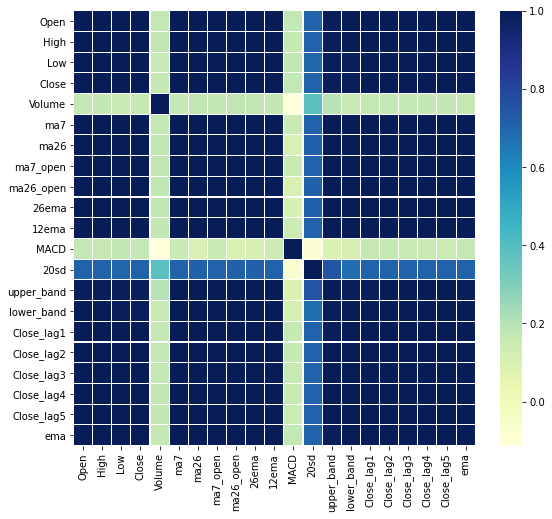

In [86]:
import seaborn as sns 
from scipy.stats import norm 

df_A_ti = get_technical_indicators(df_A)
#df_A_ti = df_A_ti.dropna()

corrmat = df_A_ti.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

In [87]:
#df_A_ti = get_technical_indicators(df_A)
#df_A_ti = df_A_ti.dropna()
#df_A_ti = df_A_ti[5:]
#df_A_ti = df_A_ti.fillna(method='backfill')
df_A_ti = df_A_ti.fillna(method='backfill')
df_A_y = df_A_ti.copy()
df_A_y = df_A_y[['Open','Close']]
#df_A_ti = df_A_ti[5:]
df_A_ti = df_A_ti[['Open','Close','High', 'Low','Volume','20sd','MACD']]
#,'Close_lag1','Close_lag2','Close_lag3','Close_lag4','Close_lag5'
#,'Adj Close','VIX_Open','VIX_High','VIX_Low','VIX_Close','VIX_Adj Close'
 #,'VIX_20sd','upper_band','lower_band']]#,'VIX_Open','VIX_High','VIX_Low','VIX_Close']]


In [88]:
df_A_ti.isna().any()
df_A_y.isna().any()

Open     False
Close    False
dtype: bool

In [89]:
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#plot_acf(df_A_ti['Close'], lags=50)
#plot_pacf(df_A_ti['Close'], lags=50)

In [90]:
args = df_A_ti.values.reshape(df_A_ti.shape[0],7)
args_y = df_A_y.values.reshape(df_A_y.shape[0],2)

In [91]:
in_seq1 = args
in_seq1_y= args_y

In [92]:
#x_scaler = MinMaxScaler().fit(args)
#X= x_scaler.transform(args)
print(in_seq1.shape)
print(in_seq1_y.shape)

(1760, 7)
(1760, 2)


In [93]:
division = len(in_seq1) - 40*3

data_train = in_seq1[:division]
data_test = in_seq1[(division-lookback_days):]

data_train_y= in_seq1_y[:division]
data_test_y = in_seq1_y[(division-lookback_days):]

In [94]:
def split_sequences(sequences, sequences_y,  n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences_y[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [95]:
X_train,y_train = split_sequences(data_train, data_train_y, lookback_days, forward_days)

In [96]:
X_features = X_train.shape[2]
y_features = y_train.shape[2]

In [97]:
X_train=X_train.reshape(X_train.shape[0],lookback_days*X_features)
y_train=y_train.reshape(y_train.shape[0],forward_days*y_features)

In [98]:
X_train.shape

(1608, 210)

In [99]:
x_scaler = MinMaxScaler()#.fit(X_train)
#x_scaler = RobustScaler(quantile_range = (0.05,0.95))
#x_scaler.fit(X_train)
#X_train = x_scaler.transform(X_train)

In [100]:
smoothing_window_size = 500
for di in range(0,1000,smoothing_window_size):
    x_scaler.fit(X_train[di:di+smoothing_window_size,:])
    X_train[di:di+smoothing_window_size,:] = x_scaler.transform(X_train[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
x_scaler.fit(X_train[di+smoothing_window_size:,:])
X_train[di+smoothing_window_size:,:] = x_scaler.transform(X_train[di+smoothing_window_size:,:])

In [101]:
y_train.max()

2039.510009765625

In [102]:
y_scaler = MinMaxScaler()#.fit(y_train)
#y_scaler = RobustScaler(quantile_range = (0.05,0.95))
#y_scaler.fit(y_train)
#y_train = y_scaler.transform(y_train)

In [103]:
smoothing_window_size = 500
for di in range(0,1000,smoothing_window_size):
    y_scaler.fit(y_train[di:di+smoothing_window_size,:])
    y_train[di:di+smoothing_window_size,:] = y_scaler.transform(y_train[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
y_scaler.fit(y_train[di+smoothing_window_size:,:])
y_train[di+smoothing_window_size:,:] = y_scaler.transform(y_train[di+smoothing_window_size:,:])

In [104]:
#y_scaler = StandardScaler()
#y_scaler.fit(df_A_ti[:df_A_ti.shape[0]-3][['Close']])
#y = y_scaler.transform(y_train)

<function matplotlib.pyplot.show>

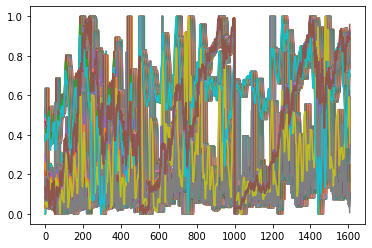

In [105]:
plt.plot(X_train)
plt.plot(y_train)
plt.show

In [106]:
X_train = X_train.reshape(X_train.shape[0], lookback_days, X_features)
#y_train = y_train.reshape(y_train.shape[0], forward_days,y_features )

In [107]:
X_train.shape

(1608, 30, 7)

In [108]:
from tensorflow.keras import backend as K
class attention(tf.keras.layers.Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [109]:
model = Sequential()
model.add((Conv1D(filters=32, kernel_size=5, activation='relu',
                                 input_shape=(30,7))))
model.add((MaxPooling1D(pool_size=2)))
model.add(Bidirectional(LSTM(100, return_sequences=True,
              activation='tanh', recurrent_activation='hard_sigmoid',kernel_initializer='random_uniform')))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=True,
              activation='relu', recurrent_activation='hard_sigmoid',kernel_initializer='random_uniform')))
model.add(Dropout(0.5))
model.add(attention(return_sequences=False))
model.add((Dense(6)))
opt = Adam(lr=0.001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',  patience=30)
model.compile(optimizer=opt, loss='mse', metrics=['mse','mae','mape'])

In [110]:
batch_size = 32
model.fit(X_train, y_train, epochs=150, verbose=1 , shuffle=True,
      callbacks=[es], batch_size=batch_size, validation_split=0.2)

Epoch 1/150
41/41 [==============================] - 12s 99ms/step - loss: 0.0992 - mse: 0.0992 - mae: 0.2334 - mape: 320028.7618 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0992 - val_mape: 13.3037
Epoch 2/150
41/41 [==============================] - 3s 75ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0809 - mape: 174043.7109 - val_loss: 0.0055 - val_mse: 0.0055 - val_mae: 0.0606 - val_mape: 8.5582
Epoch 3/150
41/41 [==============================] - 3s 73ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0699 - mape: 182699.4476 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0555 - val_mape: 7.9450
Epoch 4/150
41/41 [==============================] - 3s 73ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0842 - mape: 171788.7186 - val_loss: 0.0135 - val_mse: 0.0135 - val_mae: 0.1038 - val_mape: 13.6605
Epoch 5/150
41/41 [==============================] - 3s 73ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0675 - mape: 166936.9479 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0502 -

In [111]:
model.save('my_model') 

INFO:tensorflow:Assets written to: my_model/assets


In [112]:
y_train.max(),y_train.min()

(1.0000000000000002, 0.0)

# Testing

In [113]:
X_test, y_test = split_sequences(data_test, data_test_y, lookback_days,forward_days)
X_test_original = X_test

In [114]:
X_test=X_test.reshape(X_test.shape[0],lookback_days*X_features)
y_test=y_test.reshape(y_test.shape[0],forward_days*y_features)

In [115]:
xtest_scaler = MinMaxScaler().fit(X_test)
X_test = xtest_scaler.transform(X_test)
ytest_scaler = MinMaxScaler().fit(y_test)
#y_scaler.fit(y_test)
y_test = ytest_scaler.transform(y_test)

In [116]:
X_test = X_test.reshape(X_test.shape[0],lookback_days, X_features)
#y_test = y_test.reshape(y_test.shape[0],forward_days, y_features)

In [117]:
y_pred = model.predict(X_test,batch_size = 16)

In [118]:
evaluation = model.evaluate(X_test, y_test)
print(evaluation) #'mse','mae', 'mape'

4/4 [==============================] - 0s 14ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0845 - mape: 1233962.5000
[0.011414502747356892, 0.011414502747356892, 0.08450473099946976, 1233962.5]


In [119]:
y_pred = y_pred.reshape(y_pred.shape[0],forward_days*y_features)
y_pred = ytest_scaler.inverse_transform(y_pred)

In [120]:
#y_pred = y_pred.reshape(y_pred.shape[0],forward_days,y_features)

In [121]:
y_test = y_test.reshape(y_test.shape[0],forward_days*y_features)
#y_true = y_test
y_true = ytest_scaler.inverse_transform(y_test)

In [122]:
X_test = X_test.reshape(X_test.shape[0],lookback_days*X_features)
X_test = xtest_scaler.inverse_transform(X_test)
#y_true = y_true.reshape(y_true.shape[0],forward_days,y_features)

In [123]:
diff_true = array([y_true[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])
diff_pred = array([y_pred[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])

In [124]:
diff_true1 = array([y_true[:,x] - X_test_original[:,1,-1] for x in [1,3,5]])
diff_true2 = array([y_true[:,x] - X_test_original[:,0,-1] for x in [0,2,4]])
diff_true=np.concatenate((diff_true1,diff_true2),axis=1)

In [125]:
diff_pred1 = array([y_pred[:,x] - X_test_original[:,1,-1] for x in [1,3,5]])
diff_pred2 = array([y_pred[:,x] - X_test_original[:,0,-1] for x in [0,2,4]])
diff_pred=np.concatenate((diff_pred1,diff_pred2),axis=1)

In [126]:
def rsquared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [127]:
y_bar = y_true.mean()
ss_tot = ((y_true-y_bar)**2).sum()
ss_res = ((y_true-y_pred)**2).sum()
print(ss_res)
print(ss_tot)

y_bar = diff_true.mean()
ss_tot = ((diff_true-y_bar)**2).sum()
ss_res = ((diff_true-diff_pred)**2).sum()
print(ss_res)
print(ss_tot)

829201.5130502882
3826309.3373111063
829201.5130502882
4129745.0716387155


# MSE MAE RMSE

In [128]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(y_true, y_pred)
mae_diff = metrics.mean_absolute_error(diff_true, diff_pred)
mse_diff = metrics.mean_squared_error(diff_true, diff_pred)
rmse_diff = np.sqrt(mse_diff) #mse**(0.5)  
r2_diff = rsquared(diff_true, diff_pred)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)
print("MAE_diff:",mae_diff)
print("MSE_diff:", mse_diff)
print("RMSE_diff:", rmse_diff)
print("R-Squared diff:", r2_diff)

Results of sklearn.metrics:
MAE: 27.0945375948976
MSE: 1171.1885777546443
RMSE: 34.222632536884774
R-Squared: 0.7832894729747596
MAE_diff: 27.09453759489761
MSE_diff: 1171.1885777546443
RMSE_diff: 34.222632536884774
R-Squared diff: 0.799212421428896


In [129]:
y_pred_len = y_pred.shape[0]

In [130]:
dataset = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]
                        })
dataset_true = pd.DataFrame({
    'open': y_true[:,0], 'close': y_true[:,1]
                        })
dataset.loc[:,'date'] = pd.to_datetime(df_A[-y_pred_len-2:-2].index)
dataset_true.loc[:,'date'] = pd.to_datetime(df_A[-y_pred_len-2:-2].index)

In [131]:
dataset=dataset.assign(low=lambda d: d[['open', 'close']].min(1))
dataset=dataset.assign(high=lambda d: d[['open', 'close']].max(1))
dataset_true=dataset_true.assign(low=lambda d: d[['open', 'close']].min(1))
dataset_true=dataset_true.assign(high=lambda d: d[['open', 'close']].max(1))

In [132]:
%pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

  Using cached https://github.com/matplotlib/mpl_finance/archive/master.zip
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp37-none-any.whl size=8424 sha256=649b00890bff3ec77721750d276f3aa1e9d74ca4372532acefa7f625859474d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-d4vx9rl7/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


In [133]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime as dt
import mpl_finance as mpf 

In [134]:
import plotly.graph_objects as go

fig = go.Figure(data=
                [go.Ohlc(x=dataset['date'],
                open=dataset['open'],
                high=dataset['high'],
                low=dataset['low'],
                close=dataset['close'],
                showlegend=False,
                name="predicted"),
                 go.Ohlc(x=dataset_true['date'],
                open=dataset_true['open'],
                high=dataset_true['high'],
                low=dataset_true['low'],
                close=dataset_true['close'],
                showlegend=False,
                name="true",
    increasing_line_color= 'cyan', decreasing_line_color= 'gray'
)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [135]:
%pip install yfinance

# Evaluation

In [136]:
import yfinance as yf
ticker = 'GOOG'
index = yf.Ticker(ticker)

# get historical market data
hist = index.history(start='2020-06-01', end= '2020-12-30', actions=False)

In [137]:
def test_data_prediction(df_test):
  #df_test['Date'] = pd.to_datetime(df_test['Date'])
  #df_test.set_index('Date', inplace=True)



  df_test_ti = get_technical_indicators(df_test)
  #df_test_ti = df_test_ti.dropna()
  df_test = df_test.fillna(method='backfill')
  df_test_y = df_test.copy()
  df_test_y = df_test_y[['Open','Close']]
  df_test_ti = df_test_ti[['Open','Close','High', 'Low','Volume','20sd','MACD']]

  args_test = df_test_ti.values.reshape(df_test_ti.shape[0],7)
  args_test_y = df_test_y.values.reshape(df_test_y.shape[0],2)

  in_seq_test = args_test
  in_seq_test_y = args_test_y

  division =  lookback_days

  data_train = in_seq_test[:division]
  data_test = in_seq_test[(division-lookback_days):]

  data_train_y = in_seq_test_y[:division]
  data_test_y = in_seq_test_y[(division-lookback_days):]

  X_test, y_test = split_sequences(data_test, data_test_y, lookback_days,forward_days)

  X_features = X_test.shape[2]
  y_features = y_test.shape[2]
  X_test_original = X_test
  X_test=X_test.reshape(X_test.shape[0],lookback_days*X_features)
  y_test=y_test.reshape(y_test.shape[0],forward_days*y_features)

  xtest_scaler = MinMaxScaler().fit(X_test)
  X_test = xtest_scaler.transform(X_test)
  ytest_scaler = MinMaxScaler().fit(y_test)
  #y_scaler.fit(y_test)
  y_test = ytest_scaler.transform(y_test)

  X_test = X_test.reshape(X_test.shape[0],lookback_days, X_features)

  y_pred = model.predict(X_test,batch_size = 16)
  y_pred = y_pred.reshape(y_pred.shape[0],forward_days*y_features)
  y_hat = ytest_scaler.inverse_transform(y_pred)

  y_test = y_test.reshape(y_test.shape[0],forward_days*y_features)
  #y_true = y_test
  y_true = ytest_scaler.inverse_transform(y_test)

  return y_test,y_true,y_pred,y_hat,X_test_original

In [138]:
y_test1,y_true1,y_pred1,y_hat1, X_test_original1 = test_data_prediction(hist)

In [139]:
y_test=y_test1
y_true=y_true1
y_pred=y_pred1
y_hat=y_hat1
X_test_original = X_test_original1

In [140]:
diff_true = array([y_true[:,x] - X_test_original[:,1,-1] for x in [0,1,2,3,4,5]])
diff_pred = array([y_hat[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])

In [141]:
diff_true1 = array([y_true[:,x] - X_test_original[:,1,-1] for x in [1,3,5]])
diff_true2 = array([y_true[:,x] - X_test_original[:,0,-1] for x in [0,2,4]])
diff_true=np.concatenate((diff_true1,diff_true2),axis=1)

In [142]:
diff_pred1 = array([y_hat[:,x] - X_test_original[:,1,-1] for x in [1,3,5]])
diff_pred2 = array([y_hat[:,x] - X_test_original[:,0,-1] for x in [0,2,4]])
diff_pred=np.concatenate((diff_pred1,diff_pred2),axis=1)

In [143]:
#diff_pred[diff_pred<0] = - diff_pred[diff_pred<0]
#diff_true[diff_true<0] = - diff_true[diff_true<0]

In [144]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(y_true, y_hat)
mse = metrics.mean_squared_error(y_true, y_hat)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(y_true, y_hat)
mae_diff = metrics.mean_absolute_error(diff_true, diff_pred)
mse_diff = metrics.mean_squared_error(diff_true, diff_pred)
rmse_diff = np.sqrt(mse_diff) #mse**(0.5)  
r2_diff = rsquared(diff_true, diff_pred)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)
print("MAE_diff:",mae_diff)
print("MSE_diff:", mse_diff)
print("RMSE_diff:", rmse_diff)
print("R-Squared diff:", r2_diff)

Results of sklearn.metrics:
MAE: 36.542091983488234
MSE: 2254.6608881108327
RMSE: 47.483269560033804
R-Squared: 0.8437297124373707
MAE_diff: 36.542091983488234
MSE_diff: 2254.660888110833
RMSE_diff: 47.483269560033804
R-Squared diff: 0.8472377581663748


In [145]:
y_bar = y_true.mean()
ss_tot = ((y_true-y_bar)**2).sum()
ss_res = ((y_true-y_hat)**2).sum()
print(ss_res)
print(ss_tot)

y_bar = diff_true.mean()
ss_tot = ((diff_true-y_bar)**2).sum()
ss_res = ((diff_true-diff_pred)**2).sum()
print(ss_res)
print(ss_tot)
print(ss_res/ss_tot)

1569243.9781251396
10041857.621182308
1569243.9781251396
10272459.734089388
0.15276224183362513


In [146]:
y_pred=y_hat
y_pred_len = y_pred.shape[0]

In [147]:
new_row1 = {'open':y_pred[-2,2] , 'close':y_pred[-2,3]}
new_row2 = {'open':y_pred[-1,4] , 'close':y_pred[-1,4]}

In [148]:
from datetime import timedelta

dataset = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]
                        })

dataset_true = pd.DataFrame({
    'open': y_true[:,0], 'close': y_true[:,1]
                        })

tempDf = pd.to_datetime(hist[-y_pred_len-2:-2].index)
dataset.loc[:,'date'] = pd.to_datetime(hist[-y_pred_len-2:-2].index)
dataset_true.loc[:,'date'] = pd.to_datetime(hist[-y_pred_len-2:-2].index)

dataset = dataset.append(new_row1, ignore_index=True)
dataset = dataset.append(new_row2, ignore_index=True)
dataset.loc[y_pred_len,'date'] = pd.to_datetime(tempDf[-1] + timedelta(days=1))
dataset.loc[y_pred_len+1,'date'] = pd.to_datetime(tempDf[-1] + timedelta(days=2))

In [149]:
dataset=dataset.assign(low=lambda d: d[['open', 'close']].min(1))
dataset=dataset.assign(high=lambda d: d[['open', 'close']].max(1))
dataset_true=dataset_true.assign(low=lambda d: d[['open', 'close']].min(1))
dataset_true=dataset_true.assign(high=lambda d: d[['open', 'close']].max(1))

In [150]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

fig = go.Figure(data=
                [go.Ohlc(x=dataset['date'],
                open=dataset['open'],
                high=dataset['high'],
                low=dataset['low'],
                close=dataset['close'],
                showlegend=False,
                name="predicted"),
                 go.Ohlc(x=dataset_true['date'],
                open=dataset_true['open'],
                high=dataset_true['high'],
                low=dataset_true['low'],
                close=dataset_true['close'],
                showlegend=False,
                name="true",
    increasing_line_color= 'blue', decreasing_line_color= 'yellow'
)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()


In [151]:
!zip -r /content/my_model.zip /content/my_model

from google.colab import files
#files.download("/content/my_model.zip")

updating: content/my_model/ (stored 0%)
updating: content/my_model/saved_model.pb (deflated 90%)
updating: content/my_model/variables/ (stored 0%)
updating: content/my_model/variables/variables.index (deflated 70%)
updating: content/my_model/variables/variables.data-00000-of-00001 (deflated 6%)
updating: content/my_model/assets/ (stored 0%)


In [152]:
#files.download("/content/my_model.zip")